# YOLO - Aula prática

## Configurações

Importando módulos necessários

In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCDetection
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm.notebook import tqdm

## Introdução

Yolo é um algoritmo de detecção de objetos próximo ao estado da arte. Foi desenvolvido por Joseph Redmon. A maior vantagem sobre outras arquiteturas é a velocidade sem muita preocupação com a precisão, mas que entregam resultados comparáveis com modelos mais lentos. Os modelos da família de modelos Yolo são realmente rápidos, muito mais rápidos que o R-CNN e outros. Neste artigo vamos passar pela primeira versão do yolo (yolov1) sua arquitetura, como funciona e sua implementação no pytorch.

## Implementando a YOLO

Como a yolo trabalha olhando para cada imagem apenas uma vez, a janela deslizante não é uma boa abordagem. Em vez disso, a imagem inteira pode ser dividida em grades de tamanho de células SxS. Agora, cada célula será responsável por prever coisas diferentes.

Normalmente, como é o caso de todos os detectores de objetos, os recursos aprendidos pelas camadas convolucionais são passados para um classificador/regressor que faz a previsão da detecção. Por exemplo, as coordenadas das caixas delimitadoras, o rótulo da classe etc., mas na YOLO, a previsão é feita usando uma camada convolucional que usa convoluções 1 x 1 . (obs.: A yolov1 descrita no [artigo original](https://arxiv.org/pdf/1506.02640) utiliza uma camada densa como camada final, mas para esta demonstração, achamos interessante trazer a camada de predição convolucional introduzida no artigo da [yolov2](https://arxiv.org/pdf/1612.08242))

O importante a observar é que a saída é um mapa de ativação. Cada célula desses mapas de ativação prevê coisas diferentes. Cada célula preverá: 4 coordenadas para caixa delimitadora, a probabilidade de caixa delimitadora conter objeto e probabilidades de classe para cada da classe. Caso não haja objeto em alguma célula da grade, é importante que o valor de confiança seja muito baixo para essa célula. Para o conjunto de dados [Pascal VOC](https://docs.ultralytics.com/datasets/detect/voc/), temos 20 classes.

Temos $ (C + B \times 5) $ entradas no mapa de ativação. B representa o número de caixas delimitadoras que cada célula pode prever. Cada uma das caixas delimitadoras tem 5 atributos, que descrevem as coordenadas centrais, as dimensões, a pontuação de probabilidade da caixa delimitadora, e cada célula possui a probabilidade de classe C para suas caixas delimitadoras. O YOLO v1 prevê 2 caixas delimitadoras para cada célula. Portanto, no total, cada célula preverá 30 valores.

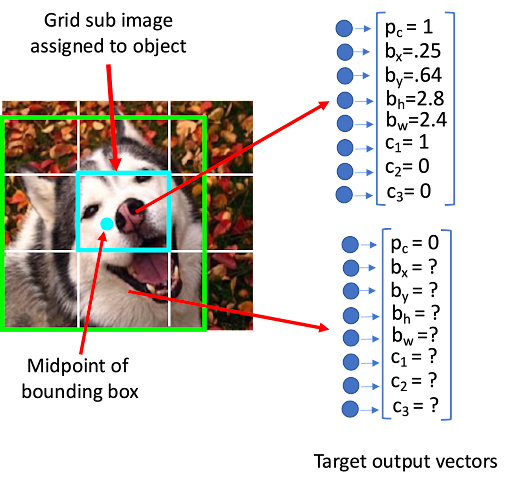

A arquitetura utilizada no artigo original é a seguinte:

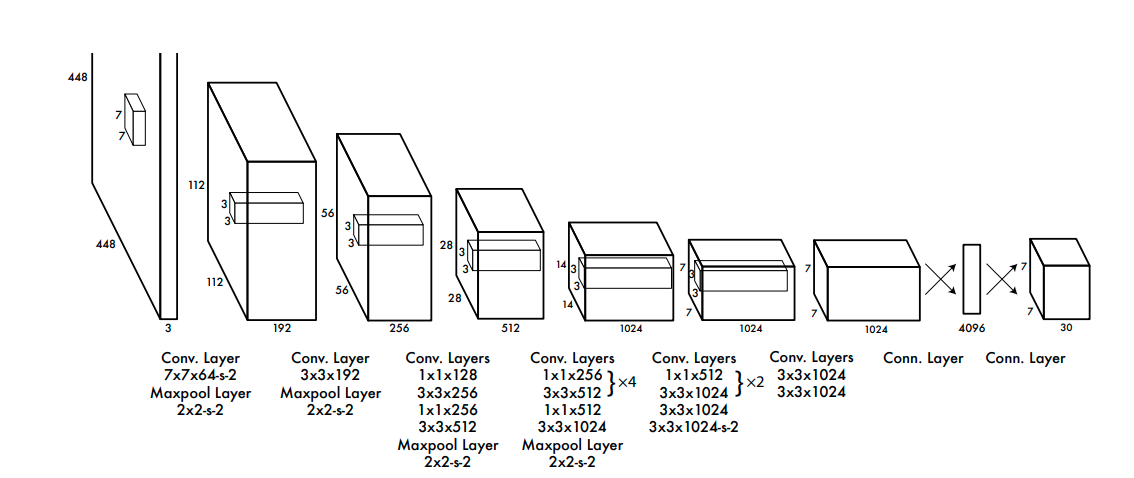

In [3]:
"""
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding)
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [4]:
# bloco utilizado na arquitetura
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [5]:
class YOLOv1(nn.Module):
    def __init__(self, architecture_config=architecture_config, in_channels=3, split_size=7, num_boxes=2, num_classes=20, use_conv=False):
        super(YOLOv1, self).__init__()
        self.S, self.B, self.C = split_size, num_boxes, num_classes
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)

        self.use_conv = use_conv
        if use_conv:
            self.fcs = self._create_cnn_fcs()
        else:
            self.fcs = self._create_fcs()

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for layer in architecture:
            if type(layer) == tuple:
                layers.append(CNNBlock(
                    in_channels, layer[1], kernel_size=layer[0], stride=layer[2], padding=layer[3],
                ))
                in_channels = layer[1]
            elif type(layer) == str:
                if layer == "M":
                    layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
                else:
                    raise Exception('Unknown layer type')
            elif type(layer) == list:
                for _ in range(layer[-1]):
                    for sublayer in layer[:-1]:
                        layers.append(CNNBlock(
                            in_channels, sublayer[1], kernel_size=sublayer[0], stride=sublayer[2], padding=sublayer[3],
                        ))
                        in_channels = sublayer[1]
            else:
                raise Exception('Unknown layer type')

        return nn.Sequential(*layers)

    def _create_fcs(self):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * self.S * self.S, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.C + self.B * 5)),
        )

    def _create_cnn_fcs(self):
        return nn.Conv2d(1024, self.C + self.B * 5, kernel_size=1)

    def forward(self, x):
        x = self.darknet(x)
        x = self.fcs(x)
        # converte para o formato (B, S, S, C + B * 5)
        if self.use_conv:
            x = x.permute(0, 2, 3, 1)
        else:
            x = x.reshape(-1, self.S, self.S, self.C + self.B * 5)
        return x

In [6]:
yolo = YOLOv1(use_conv=True)
summary(yolo, (3, 448, 448), batch_size=16, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           9,408
       BatchNorm2d-2         [16, 64, 224, 224]             128
         LeakyReLU-3         [16, 64, 224, 224]               0
          CNNBlock-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 192, 112, 112]         110,592
       BatchNorm2d-7        [16, 192, 112, 112]             384
         LeakyReLU-8        [16, 192, 112, 112]               0
          CNNBlock-9        [16, 192, 112, 112]               0
        MaxPool2d-10          [16, 192, 56, 56]               0
           Conv2d-11          [16, 128, 56, 56]          24,576
      BatchNorm2d-12          [16, 128, 56, 56]             256
        LeakyReLU-13          [16, 128, 56, 56]               0
         CNNBlock-14          [16, 128,

## Função de perda

A função de perda definida no artigo da yolo é a seguinte:

$$
\lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^B 𝟙_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] + \\
\lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^B 𝟙_{ij}^{\text{obj}} \left[ \left( \sqrt{w_i} - \sqrt{\hat{w}_i} \right)^2 + \left( \sqrt{h_i} - \sqrt{\hat{h}_i} \right)^2 \right] + \\
\sum_{i=0}^{S^2} \sum_{j=0}^B 𝟙_{ij}^{\text{obj}} \left( C_i - \hat{C}_i \right)^2 + \\
\lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^B 𝟙_{ij}^{\text{noobj}} \left( C_i - \hat{C}_i \right)^2 + \\
\sum_{i=0}^{S^2} 𝟙_i^{\text{obj}} \sum_{c \in \text{classes}} \left( p_i(c) - \hat{p}_i(c) \right)^2
$$

com $ 𝟙_{i}^{\text{obj}} $ representando se existe um objeto na célula $ i $ e $ 𝟙_{ij}^{\text{obj}} $ representando que a *bounding box* $ j $ é responsável pela predição do objeto na célula $ i $ (possui o maior *IoU* com a label)

O *IoU* (Intersection over Union) é uma medida de similaridade entre bounding boxes, medindo o tamanho da parte onde as bounding boxes se encontram sobre a área total, quanto maior o *IoU*, mais similares são as áreas

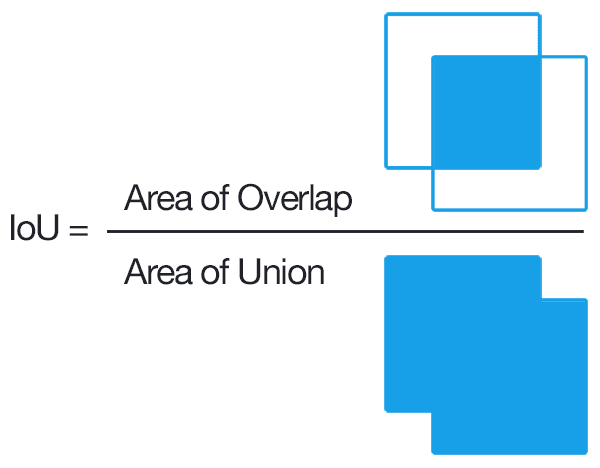

In [7]:
def iou(bbox1, bbox2):
    """
    Calculates Intersection over Union
    Parameters:
        bbox1 (tensor): the first bounding box - format = (batch_size, 4) [bx, by, bw, bh]
        bbox2 (tensor): the second bounding box - format = (batch_size, 4) [bx, by, bw, bh]
    Returns:
        tensor: Intersection over union for two boxes
    """

    # obtem as coordenadas dos cantos dos bounding boxes
    box1_x1 = bbox1[..., 0] - bbox1[..., 2] / 2
    box1_y1 = bbox1[..., 1] - bbox1[..., 3] / 2
    box1_x2 = bbox1[..., 0] + bbox1[..., 2] / 2
    box1_y2 = bbox1[..., 1] + bbox1[..., 3] / 2
    box2_x1 = bbox2[..., 0] - bbox2[..., 2] / 2
    box2_y1 = bbox2[..., 1] - bbox2[..., 3] / 2
    box2_x2 = bbox2[..., 0] + bbox2[..., 2] / 2
    box2_y2 = bbox2[..., 1] + bbox2[..., 3] / 2

    # TODO: obtenha as coordenadas dos cantos do bounding box de interseção
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # TODO: calcule a interseção dos bounding boxes
    # obs.: tome cuidado com o caso onde não há interseção!
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # TODO: calcule a área dos bounding boxes
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # TODO: calcula a interseção sobre a união
    # obs.: tome cuidado com divisão por zero!
    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [8]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20, lambda_noobj=0.5, lambda_coord=5, use_sigmoid=False, use_softmax=False):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        # no artigo original, não é utilizado sigmoid, no entanto, ela costuma ter resultados melhores
        self.use_sigmoid = use_sigmoid
        self.use_softmax = use_softmax
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = lambda_noobj
        self.lambda_coord = lambda_coord

    def forward(self, predictions, target, verbose=False):
        # Calculate IoU for the two predicted bounding boxes with target bbox
        # [ 0, 1, 2, 3, 4, 6,  7,  ..., 25  ]
        # [ p, x, y, w, h, c1, c2, ..., c20 ]
        bboxes = predictions[..., :5*self.B].reshape(-1, self.S, self.S, self.B, 5)
        target_bbox = target[..., :5].reshape(-1, self.S, self.S, 1, 5)

        ious = iou(bboxes, target_bbox)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        _, bestbox = torch.max(ious, dim=-1, keepdims=True)
        exists_box = target_bbox[..., 0]  # in paper this is Iobj_i

        bestbox_idx = bestbox.repeat(1, 1, 1, self.B)

        # # bb_idxs -> (Batch_size, S, S, B)
        bb_idxs = (torch.arange(self.B).reshape(1, 1, 1, self.B).expand_as(bestbox_idx)
                   .to(predictions.device))

        ## is_max_iou_box -> (Batch_size, S, S, B)
        # # only the index which is max iou boxes index will be 1 rest all 0
        is_max_iou_box = (bestbox_idx == bb_idxs).long().unsqueeze(-1)

        bestbox_prediction = exists_box * torch.sum(is_max_iou_box * bboxes, dim=-2)
        box_targets = exists_box * target[..., :5]

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.

        # Take sqrt of width, height of boxes to ensure that
        bestbox_prediction[..., 3:] = torch.sign(bestbox_prediction[..., 3:]) * torch.sqrt(
            torch.abs(bestbox_prediction[..., 3:] + 1e-6)
        )
        box_targets[..., 3:] = torch.sqrt(box_targets[..., 3:])

        box_loss = self.mse(
            torch.flatten(bestbox_prediction[..., 1:], end_dim=-2),
            torch.flatten(box_targets[..., 1:], end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        object_prediction = bestbox_prediction[..., 0]

        # uses sigmoid to convert the p to 0-1 range, makes it easier to train
        if self.use_sigmoid:
            object_prediction = self.sigmoid(bestbox_prediction[..., 0])

        object_loss = self.mse(
            torch.flatten(object_prediction),
            torch.flatten(box_targets[..., 0]),
        )

         # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        max_no_obj, _ = torch.max(bboxes[..., 0], dim=-1, keepdims=True)

        # uses sigmoid to convert the p to 0-1 range, makes it easier to train
        if self.use_sigmoid:
            max_no_obj = self.sigmoid(max_no_obj)

        no_object_loss = self.mse(
           torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
           torch.flatten((1 - exists_box) * target_bbox[..., 0], start_dim=1),
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        # uses sigmoid to convert the p to 0-1 range, makes it easier to train
        class_preds = predictions[..., self.B*5:]
        if self.use_softmax:
            class_preds = self.softmax(class_preds)

        class_loss = self.mse(
            torch.flatten(exists_box * class_preds, end_dim=-2,),
            torch.flatten(exists_box * target[..., 5:], end_dim=-2,),
        )


        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        ) / target.shape[0]

        if verbose:
            print(f"Total loss: {loss}")
            print(f"box_loss: {box_loss / target.shape[0]}, object_loss: {object_loss / target.shape[0]}, no_object_loss: {no_object_loss / target.shape[0]}, class_loss: {class_loss / target.shape[0]}")
            print(f"weighted box_loss: {self.lambda_coord * box_loss / target.shape[0]}, object_loss: {object_loss / target.shape[0]}, weighted no_object_loss: {self.lambda_noobj * no_object_loss / target.shape[0]}, class_loss: {class_loss / target.shape[0]}")

        return loss

## Dataset

Utilizaremos o conjunto de dados [Pascal VOC](https://docs.ultralytics.com/datasets/detect/voc/) para este notebook. Esse conjunto de dados foi utilizado no artigo original da yolov1 e contem imagens com anotações de 20 classes com suas bounding boxes. O módulo *torchvision* já possui esse dataset anotado.

In [9]:
# Obtendo um mapeamento de labels para índices
dataset_labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
label_map = {l: i for i, l in enumerate(dataset_labels)}

A transformação abaixo vai pegar as anotações do dataset e convertê-las em um formato mais fácil de trabalhar $ [ c, b_x, b_y, b_w, b_h ] $ contendo o índice da classe **c** como definido na célula anterior, $ b_x,\space b_y,\space b_w,\space e \space b_h $ representando a coordenada (x, y) do centro da bounding box, sua largura e altura, regularizados entre 0 e 1, para manter todas as imagens com rótulos equivalentes, independente de tamanho.

In [10]:
class GetBoundingBoxes(object):
    def __init__(self, label_map):
        self.label_map = label_map

    def __call__(self, label):
        annotation = label['annotation']
        size = annotation['size']

        w, h = float(size['width']), float(size['height'])

        return torch.tensor([self._get_obj_annotation(obj, w, h) for obj in annotation['object']])

    def _get_obj_annotation(self, obj, img_width, img_height):
        obj_name = obj['name']

        xmin = float(obj['bndbox']['xmin'])
        ymin = float(obj['bndbox']['ymin'])
        xmax = float(obj['bndbox']['xmax'])
        ymax = float(obj['bndbox']['ymax'])

        x_center = (xmax + xmin) / 2 / img_width
        y_center = (ymax + ymin) / 2 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        return (self.label_map[obj_name], x_center, y_center, width, height)

A transformação abaixo vai utilizar as anotações obtidas anteriormente e inserí-las na grade S x S que será prevista pelo modelo, para poder ser utilizado na função de perda.

In [11]:
class GetGridBoundingBoxes(object):
    def __init__(self, S=7, B=2, C=20):
        self.S = S
        self.B = B
        self.C = C

    def __call__(self, label):
        label_matrix = torch.zeros((self.S, self.S, self.C + 5))

        for box in label:
            l, x, y, w, h = box

            # TODO: obtenha em qual célula o centro do bounding box está
            i, j = int(self.S * y), int(self.S * x)
            l = int(l)

            if label_matrix[i, j, 0] == 0:
                label_matrix[i, j, 0] = 1

                # TODO: obtenha as coordenadas do bounding box em relação à célula
                cell_x, cell_y = self.S * x - j, self.S * y - i
                cell_w, cell_h = self.S * w, self.S * h

                label_matrix[i, j, 1:5] = torch.tensor([cell_x, cell_y, cell_w, cell_h])
                label_matrix[i, j, 5+l] = 1

        return label_matrix

Abaixo, obtemos o dataset já com as imagens no tamanho 448 x 448

In [12]:
train_voc = VOCDetection('voc_dataset', image_set='train', download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((448, 448), antialias=True)]), target_transform=transforms.Compose([GetBoundingBoxes(label_map), GetGridBoundingBoxes()]))
val_voc = VOCDetection('voc_dataset', image_set='val', download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((448, 448), antialias=True)]), target_transform=transforms.Compose([GetBoundingBoxes(label_map), GetGridBoundingBoxes()]))

len(train_voc), len(val_voc)

Using downloaded and verified file: voc_dataset/VOCtrainval_11-May-2012.tar
Extracting voc_dataset/VOCtrainval_11-May-2012.tar to voc_dataset


(5717, 5823)

In [13]:
val_voc, test_voc = torch.utils.data.random_split(val_voc, [0.2, 0.8])

len(train_voc), len(val_voc), len(test_voc)

(5717, 1165, 4658)

## Non-Max Suppression

In [14]:
def get_valid_bounding_boxes(bboxes, threshold=0.4, x_size=448, y_size=448, S=7, C=20, B=2):
    """
    Get valid bounding boxes accorfing to a threshold.

    Parameters:
        bboxes (list of lists): Bounding boxes outputted by the model.
        threshold (float): Threshold for confidence score.

    Returns:
        list: Bounding boxes after applying NMS.
    """
    boxes = []
    for i, row in enumerate(bboxes):
        for j, bbox in enumerate(row):
            _, l = torch.max(bbox[-C:], dim=0)
            for k in range(B):
                # discards boxes with low confidence
                if bbox[k*5] < threshold:
                    continue

                p, x, y, w, h = bbox[k*5:(k+1)*5]

                # TODO: converta as bounding boxes para coordenadas globais
                x, y = (j + x)*x_size/S, (i + y)*y_size/S
                w, h = (w/S)*x_size, (h/S)*y_size

                boxes.append([l.item(), p.item(), x.item(), y.item(), w.item(), h.item()])

    return boxes

In [15]:
def non_max_suppression(bboxes, iou_threshold=0.5, threshold=0.4, x_size=448, y_size=448, S=7, C=20, B=2):
    """
    Performs Non-Max Suppression on bounding boxes.

    Parameters:
        bboxes (list of lists): Bounding boxes outputted by the model.
        iou_threshold (float): Threshold for IoU.
        threshold (float): Threshold for confidence score.

    Returns:
        list: Bounding boxes after applying NMS.
    """
    # Filter out boxes with low confidence scores
    bboxes = get_valid_bounding_boxes(bboxes, threshold, x_size, y_size, S, C, B)
    # Sort boxes by confidence score in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    nms_bboxes = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        nms_bboxes.append(chosen_box)
        bboxes = [
            box
            for box in bboxes
            # TODO: inclua a condição de IoU
            if box[0] != chosen_box[0] or iou(torch.tensor(chosen_box[2:]), torch.tensor(box[2:])) < iou_threshold
        ]

    return nms_bboxes

In [16]:
def get_colors():
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    i = 0
    while True:
        yield colors[i]
        i = (i + 1) % len(colors)

def plot_sample(sample, threshold=0.4, iou_threshold=0.5, show_bboxes=True, show_labels=True, show_midpoint=False, show_cells=False, x_size=448, y_size=448, S=7, C=20, B=2):
    fig, ax = plt.subplots()
    img, label = sample
    bboxes = non_max_suppression(label, iou_threshold, threshold, x_size, y_size, S, C, B)
    plt.imshow(img.permute(1,2,0), interpolation='nearest')

    if show_bboxes:
        colors = get_colors()

        for l, p, x, y, w, h in bboxes:
            c = next(colors)
            rect = patches.Rectangle(((x-w/2), (y-h/2)), w, h, linewidth=1, edgecolor=c, facecolor='none')
            ax.add_patch(rect)
            if show_labels:
                plt.text((x-w/2)+6, (y-h/2)-8, f'{dataset_labels[int(l)]} - {min(p*100, 100):.0f}%', backgroundcolor=c, fontsize=8)
            if show_midpoint:
                plt.plot(x,y,c+'x')

    ax.axis('off')
    if show_cells:
        ax.axis('on')
        x_major_ticks = np.arange(0, x_size, x_size/S)
        y_major_ticks = np.arange(0, y_size, y_size/S)

        ax.set_xticks(x_major_ticks)
        ax.set_yticks(y_major_ticks)

        plt.grid()
    ax.set_xlim(0, x_size)
    ax.set_ylim(448, 0)
    plt.show()

A imagem abaixo é um bom teste para non-max suppression

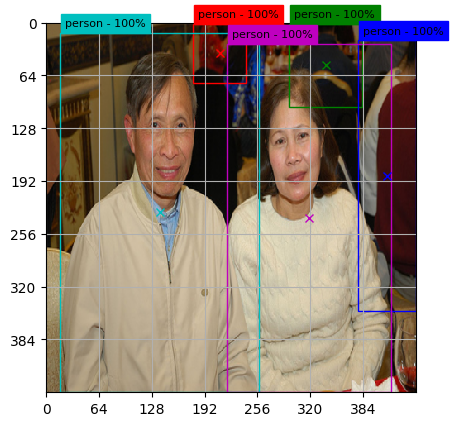

In [17]:
# B = 1 pois a label só possui uma bounding box
plot_sample(train_voc[555], show_cells=True, B=1, show_midpoint=True)

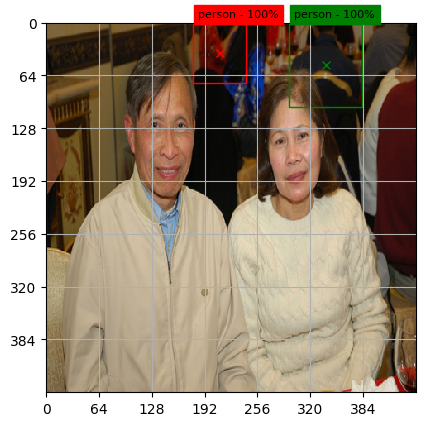

In [18]:
# B = 1 pois a label só possui uma bounding box
plot_sample(train_voc[555], show_cells=True, B=1, threshold=0.4, iou_threshold=0.01, show_midpoint=True)

## Treinando o modelo

In [19]:
train_loader = DataLoader(train_voc, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_voc, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_voc, batch_size=16, shuffle=True, drop_last=True)

In [20]:
# TODO: defina as variáveis abaixo para treinar o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLOv1(architecture_config=architecture_config, split_size=7, num_boxes=2, num_classes=20, use_conv=True).to(device)
optimizer = optim.Adam(
    yolo.parameters(), lr=5e-5, weight_decay=0
)
loss_fn = YoloLoss(lambda_coord=5, use_sigmoid=True, use_softmax=True)

In [21]:
def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                    val_loss += loss.item()

            val_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}")


In [22]:
train(yolo, optimizer, loss_fn, train_loader, val_loader, device=device, epochs=8)

  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 1/8: Train Loss: 31.6717 | Val Loss: 24.2045


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 2/8: Train Loss: 23.4003 | Val Loss: 22.6382


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 3/8: Train Loss: 22.4243 | Val Loss: 22.6555


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 4/8: Train Loss: 21.5939 | Val Loss: 22.9562


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 5/8: Train Loss: 21.1767 | Val Loss: 22.6755


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 6/8: Train Loss: 20.5345 | Val Loss: 22.3443


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 7/8: Train Loss: 19.8957 | Val Loss: 22.2283


  0%|          | 0/357 [00:00<?, ?batch/s]

Epoch 8/8: Train Loss: 19.3138 | Val Loss: 22.1738


In [67]:
sample = next(iter(train_loader))
inputs, targets = sample
preds = yolo(inputs.to(device))

loss = loss_fn(preds, targets.to(device), verbose=True)

Total loss: 19.936922073364258
box_loss: 0.8294791579246521, object_loss: 13.225313186645508, no_object_loss: 0.7842015027999878, class_loss: 2.1721112728118896
weighted box_loss: 4.147395610809326, object_loss: 13.225313186645508, weighted no_object_loss: 0.3921007513999939, class_loss: 2.1721112728118896


In [68]:
preds[..., 0] = torch.sigmoid(preds[..., 0])
preds[..., 5] = torch.sigmoid(preds[..., 5])
preds[..., -20:] = torch.softmax(preds[..., -20:], dim=-1)

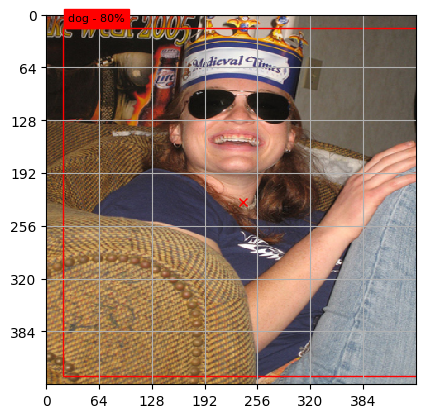

In [69]:
plot_sample((inputs[0], preds[0].cpu().detach()), show_bboxes=True, show_labels=True, show_midpoint=True, show_cells=True)

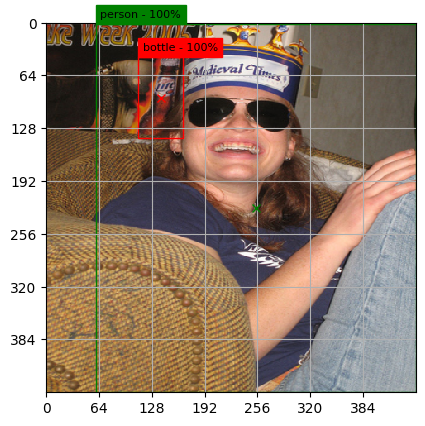

In [70]:
plot_sample((inputs[0], targets[0].cpu().detach()), show_bboxes=True, show_labels=True, show_midpoint=True, show_cells=True, B=1)

In [27]:
def validate(model, loss_fn, loader, device='cpu'):
    model.to(device)
    cum_loss = 0.0

    for i, (inputs, targets) in (pbar := tqdm(enumerate(loader), total=len(loader), unit='batch')):
        model.eval()

        with torch.no_grad():
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            cum_loss += loss.item()
            pbar.set_description(f"Loss: {cum_loss/(i+1):.4f}")

    cum_loss /= len(loader)

    print(f"Loss: {cum_loss:.4f}")

In [28]:
validate(yolo, loss_fn, test_loader, device=device)

  0%|          | 0/291 [00:00<?, ?batch/s]

Loss: 22.1651
